# 1 Import Packages

In [6]:
import xarray as xr
import numpy as np
import os

import src.config as config
import src.utils as utils

import pandas as pd
from tqdm import tqdm

import innvestigate
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import tensorflow as tf
tf.compat.v1.disable_eager_execution()


# 2 Metadata

In [7]:
ml_transform_path = os.path.join(config.data_pro_path,"ml_transform")

In [22]:
lev_index = 1

In [23]:
train_data_amoc_depth_1020_lat_26_samplestd  = xr.load_dataset(os.path.join(ml_transform_path,"train_data_amoc_depth_1020_lat_26_samplestd.nc" ))["atlantic_moc"]
train_data_amoc_depth_1020_lat_26_samplemean = xr.load_dataset(os.path.join(ml_transform_path,"train_data_amoc_depth_1020_lat_26_samplemean,nc"))["atlantic_moc"]

In [24]:
train_x_filename = "train_data_stack_lonlatstandardized.nc"
valid_x_filename = "valid_data_stack_lonlatstandardized.nc"

train_y_filename = "train_data_amoc_depth_1020_lat_26_samplestandardized.nc"
valid_y_filename = "valid_data_amoc_depth_1020_lat_26_samplestandardized.nc"

# 3 Load Data

In [25]:
train_x_xr = xr.open_dataset(os.path.join(ml_transform_path, train_x_filename)).isel(lev=lev_index)
valid_x_xr = xr.open_dataset(os.path.join(ml_transform_path, valid_x_filename)).isel(lev=lev_index)

In [26]:
train_y_xr = xr.open_dataset(os.path.join(ml_transform_path, train_y_filename))
valid_y_xr = xr.open_dataset(os.path.join(ml_transform_path, valid_y_filename))

In [27]:
train_data_amoc_depth_1020_lat_26_samplestd  = xr.load_dataset(os.path.join(ml_transform_path,"train_data_amoc_depth_1020_lat_26_samplestd.nc" ))
train_data_amoc_depth_1020_lat_26_samplemean = xr.load_dataset(os.path.join(ml_transform_path,"train_data_amoc_depth_1020_lat_26_samplemean,nc"))

# 4 Processing

In [28]:
train_x_xr_stack = train_x_xr.stack(sample=("realization","time"))
valid_x_xr_stack = valid_x_xr.stack(sample=("realization","time"))

In [29]:
train_y_xr_stack = train_y_xr.stack(sample=("realization","time"))
valid_y_xr_stack = valid_y_xr.stack(sample=("realization","time"))


In [30]:
valid_sample_coords = valid_y_xr_stack.sample
train_sample_coords = train_y_xr_stack.sample

train_x_ml_np = np.nan_to_num(np.expand_dims(train_x_xr_stack["rho"].transpose("sample",...).values,3),0)
valid_x_ml_np = np.nan_to_num(np.expand_dims(valid_x_xr_stack["rho"].transpose("sample",...).values,3),0)

train_y_ml_np = train_y_xr_stack["atlantic_moc"].values
valid_y_ml_np = valid_y_xr_stack["atlantic_moc"].values

In [31]:
train_data_amoc_depth_1020_lat_26_samplestd  = xr.load_dataset(os.path.join(ml_transform_path,"train_data_amoc_depth_1020_lat_26_samplestd.nc" ))
train_data_amoc_depth_1020_lat_26_samplemean = xr.load_dataset(os.path.join(ml_transform_path,"train_data_amoc_depth_1020_lat_26_samplemean,nc"))

In [32]:
lon = train_x_xr_stack.lon
lat = train_x_xr_stack.lat

# 5 Analyze

In [33]:
experiment_index = 1

In [34]:
model_name = "conv_level_{}_experiment_{}".format(lev_index,experiment_index)
model_path = os.path.join(config.model_path, model_name)
os.makedirs(model_path, exist_ok=True)

In [58]:
model_plot_path = os.path.join(model_path, "plots")
os.makedirs(model_plot_path, exist_ok=True)

## 5.1 History

In [35]:
csv_file = os.path.join(model_path, "history.csv")
history = pd.read_csv(csv_file)

In [36]:
np.abs(history["diff_mse_epoch_end"]).min()

0.001318236039235

In [37]:
min_epoch_diff = np.abs(history).idxmin(axis=0)["diff_mse_epoch_end"]
min_epoch_valid = history.idxmin(axis=0)["valid_mse_epoch_end"]
min_epoch_train = history.idxmin(axis=0)["train_mse_epoch_end"]

In [38]:
min_epoch_diff

29

In [39]:
history.loc[min_epoch_diff]

epoch                  29.000000
diff_mse_epoch_end      0.001318
loss                    0.410105
train_mse_epoch_end     0.395281
val_loss                0.393962
valid_mse_epoch_end     0.393962
Name: 29, dtype: float64

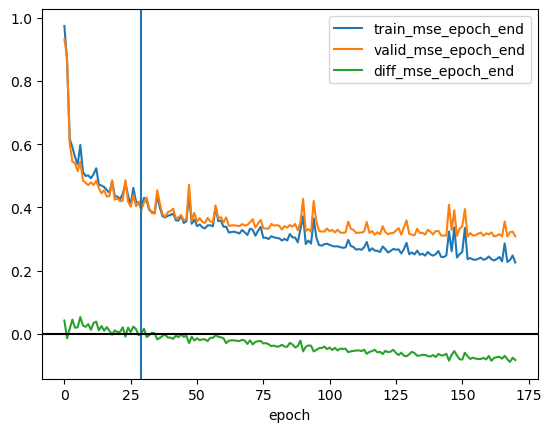

In [40]:
history.plot(x = "epoch", y = ["train_mse_epoch_end", "valid_mse_epoch_end", "diff_mse_epoch_end"])

plt.axvline(min_epoch_diff)
plt.axhline(0, color="black")

# Analyze Best Model

In [41]:
model_file_template = os.path.join(model_path, "saved-model-{epoch:02d}.hdf5")


In [79]:
# I need to add one to the minimum epoch since in the csv files the epochs start at zero
best_model_weights_file = model_file_template.format(epoch=150+1)

In [80]:
model = tf.keras.models.load_model(best_model_weights_file)

## Prediction

In [92]:
y_train_pred = model.predict(train_x_ml_np)
y_train_true = train_y_ml_np

y_valid_pred = model.predict(valid_x_ml_np)
y_valid_true = valid_y_ml_np

In [98]:
y_train_pred_xr = xr.DataArray(y_train_pred[:,0], name = "train_pred", dims = ["sample"], coords = {"sample": train_sample_coords}).unstack()
y_valid_pred_xr = xr.DataArray(y_valid_pred[:,0], name = "valid_pred", dims = ["sample"], coords = {"sample": valid_sample_coords}).unstack()

In [99]:
y_train_true_xr = train_y_xr["atlantic_moc"].rename("train_true")
y_valid_true_xr = valid_y_xr["atlantic_moc"].rename("train_true")

In [95]:
y_train_pred_rescaled_xr = y_train_pred_xr*train_data_amoc_depth_1020_lat_26_samplestd + train_data_amoc_depth_1020_lat_26_samplemean
y_train_true_rescaled_xr = y_train_true_xr*train_data_amoc_depth_1020_lat_26_samplestd + train_data_amoc_depth_1020_lat_26_samplemean
y_valid_pred_rescaled_xr = y_valid_pred_xr*train_data_amoc_depth_1020_lat_26_samplestd + train_data_amoc_depth_1020_lat_26_samplemean
y_valid_true_rescaled_xr = y_valid_true_xr*train_data_amoc_depth_1020_lat_26_samplestd + train_data_amoc_depth_1020_lat_26_samplemean

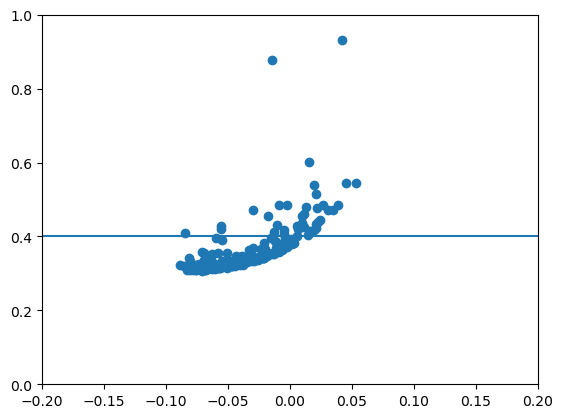

In [96]:
plt.scatter(history["diff_mse_epoch_end"].values,history["valid_mse_epoch_end"].values )

plt.xlim(-0.2,0.2)
plt.ylim(0,1)
plt.axhline(0.4)

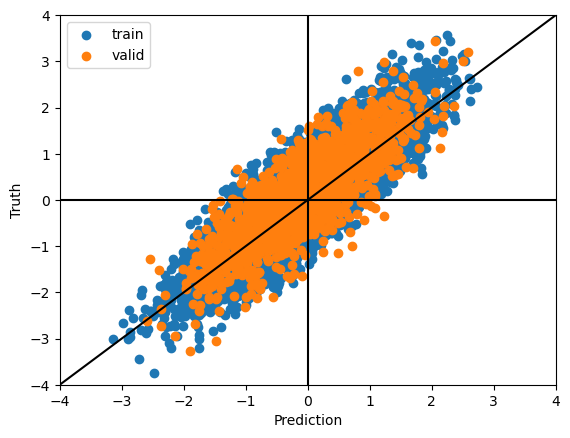

In [97]:
plt.scatter(y_train_pred, y_train_true, label="train")
plt.scatter(y_valid_pred, y_valid_true, label="valid")

x = np.arange(-4,4+1)

plt.plot(x,x, color="black")
plt.xlim(-4,4)
plt.ylim(-4,4)
plt.axhline(0, color="black")
plt.axvline(0, color="black")

plt.xlabel("Prediction")
plt.ylabel("Truth")
plt.legend()


plt.savefig(os.path.join(model_plot_path,"Performance_scatter.png"))

(0.0, 100.0)

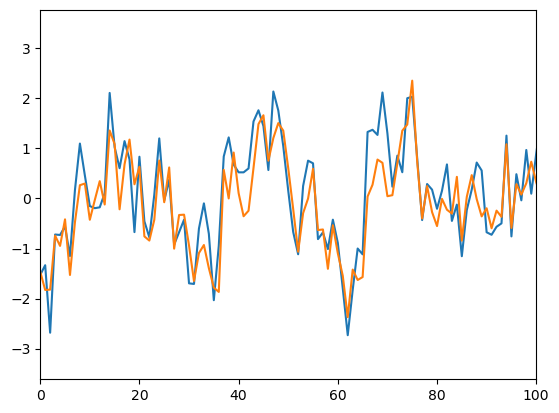

In [100]:
plt.plot(y_valid_true)
plt.plot(y_valid_pred)

plt.xlim(0,100)

(0.0, 100.0)

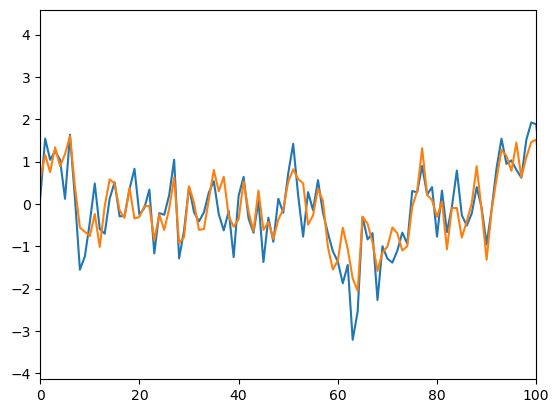

In [101]:
plt.plot(y_train_true)
plt.plot(y_train_pred)

plt.xlim(0,100)

# LRP

In [102]:
analyzer_list = ["lrp.epsilon", "lrp.z", "lrp_alpha_2_beta_1"]

In [103]:
innvestigate.create_analyzer("lrp.epsilon",model)

In [104]:
analyzer = innvestigate.create_analyzer("lrp.z", model)
heatmaps = analyzer.analyze(train_x_ml_np[:,:,:,:])
heatmaps_xr = xr.DataArray(np.squeeze(heatmaps), name="heatmap", dims = ["sample", "lat","lon"], coords = {"sample":train_sample_coords, "lon":lon,"lat":lat})

/work/uo1075/u301101/programming/miniconda3/envs/CNN/lib/python3.8/site-packages/keras/engine/training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [ ]:
plt.plot(heatmaps_xr.sum(dim=("lat","lon")))
plt.plot(y_train_pred)

plt.xlim(0,200)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10,10), subplot_kw={"projection":ccrs.PlateCarree()})

tmp = heatmaps_xr.isel(sample=134)
vmax = np.abs(tmp).quantile(0.999)


plot = ax.pcolormesh(lon, lat, tmp.transpose("lat","lon"), vmin=-vmax, vmax=vmax, transform=ccrs.PlateCarree(),cmap="RdBu_r")
ax.gridlines(xlocs=[0], ylocs = [26.5], draw_labels=True, linewidth=0.5, color='k', alpha=0.5, linestyle='--')

plt.colorbar(plot, ax = ax, orientation="horizontal")
ax.coastlines()

